<h1 style='color:#1B127A;'>
Introduction
</h1>

This notebook is used to study calculation of 

In [30]:
import pygeostat as gs
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

<h2 style='color:#5177F9;'>
Helper functions
</h2>

In [71]:
def get_stats(data, translate=[0,0], scale=[1,1], plot = True):
    
    n_var = data.ndim
    
    if n_var != 2:
        raise ValueError('Only two variables are acceptable')
    
    if (len(translate) != n_var) or (len(scale) != n_var):
        raise ValueError('translation or scale must match the number of dimension')
        
    x = scale[0]*(data.values[:,0]+translate[0]); y = scale[1]*(data.values[:,1]+translate[1])
    cov = np.cov(x,y); 
    rho= np.corrcoef(x,y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    gamma = 0.5* np.mean((x-y)**2)
    cov_calc = (cov[0][0] + cov[1][1] + (mean_x-mean_y)**2  - 2*gamma)/2
    
    print('Mean: {:.2f} {:.2f}'.format(*[mean_x, mean_y]))
    print('Variance: {:.2f} {:.2f}'.format(*[cov[0,0], cov[1,1]]))
    print('Covariance: {:.2f}'.format(cov[1,0]))
    print('Correlation Coefficient: {:.2f}'.format(rho[1,0]))
    print('Semi-Variogram: {:.2f}'.format(gamma))
    print('Calculated Covariance {:.2f}'.format(cov_calc))
    
    if plot:
        # plot scatter plot and distance from 45 degree line
        fig, axes =plt.subplots(1,2, figsize=(20,10))
        data_vis = data.sample(frac=0.1)
        x = data_vis.values[:,0]; y = data_vis.values[:,1]
        _ = gs.scatter_plot(x, y, ax=axes[0])
        gamma = 0.5*(x-y)**2
        axes[1].scatter(x,y, c=gamma, cmap='jet')
        axes[1].set_title('Semi variogram', fontsize=16)
        
        
def create_sample_data(n_sample = 100000,
                      mean= np.array([0, 0, 0, 0]),
                      cov = np.array([[1, 0.8, -0.6, 0.4],
                                      [0.8, 1, -0.5, 0.6],
                                      [-0.6, -0.5, 1, -0.4],
                                      [0.4, 0.6, -0.4, 1]])):
    
    cov_inv = np.linalg.inv(cov)
    n_mv_samples = np.random.multivariate_normal(mean, cov, n_sample).T

    data=pd.DataFrame(dtype=np.float32)
    variables = []
    for i, variable in enumerate(n_mv_samples):
        var_name = 'Variable%i'%(i+1)
        variables.append(var_name)
        data[var_name] = variable
        
    return data

<h1 style='color:#1B127A;'>
Mean, Variance, Covariance and Variogram
</h1>

In [72]:
data= create_sample_data(mean = [10, 10], cov = [[1, 0.5], [0.5, 1.0]])
data.head()

,Variable1,Variable2
0,8.807240,8.864265
1,9.664144,11.609550
2,11.394007,11.241732
3,10.997312,10.199752
4,9.643720,9.477217


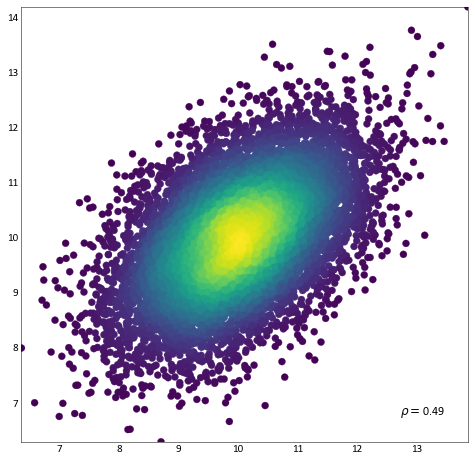

In [69]:
data_vis = data.sample(frac=0.1)
_ = gs.scatter_plot(*[data_vis[column].values for column in data_vis.columns], stat_blk=None)

Mean: 10.00 10.00
Variance: 0.99 0.99
Covariance: 0.49
Correlation Coefficient: 0.49
Semi-Variogram: 0.50
Calculated Covariance 0.49


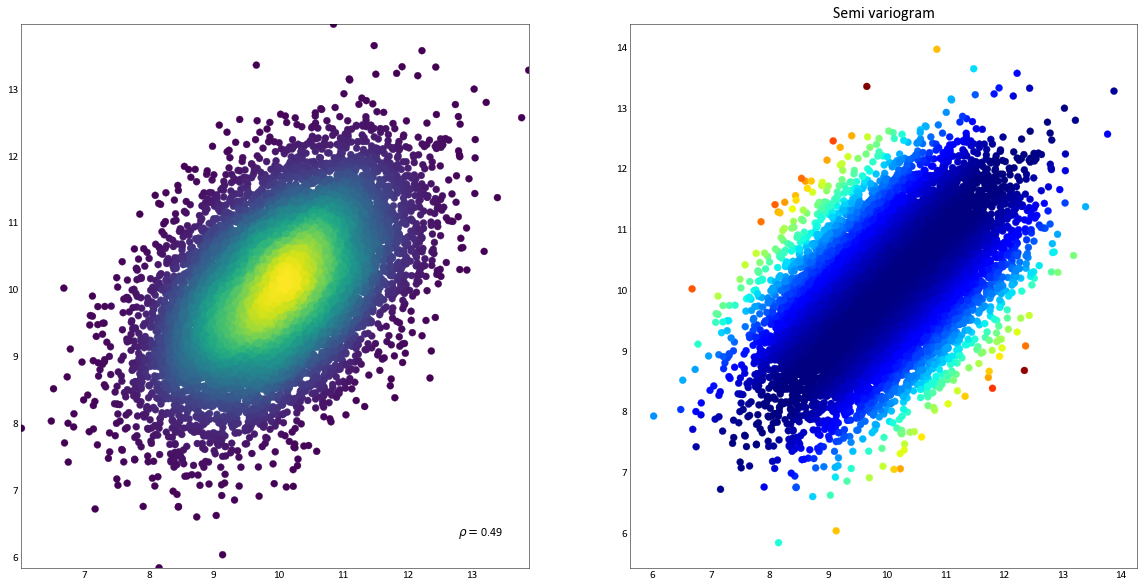

In [65]:
 get_stats(data)

<h2 style='color:#5177F9;'>
Effect of translation
</h2>

Mean: 20.00 19.99
Variance: 1.00 1.00
Covariance: 0.50
Correlation Coefficient: 0.50
Semi-Variogram: 0.50
Calculated Covariance 0.50


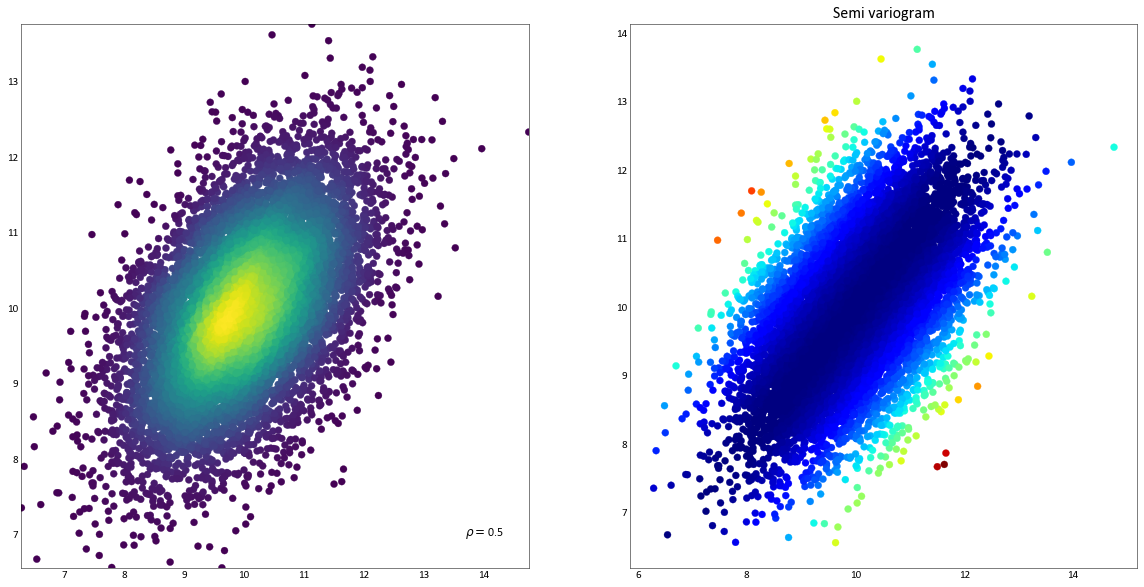

In [74]:
get_stats(data, translate=[10, 10], scale=[1, 1])

<h2 style='color:#5177F9;'>
Effect of scaling
</h2>

Mean: 21.99 32.97
Variance: 4.00 9.01
Covariance: 2.99
Correlation Coefficient: 0.50
Semi-Variogram: 63.81
Calculated Covariance 2.99


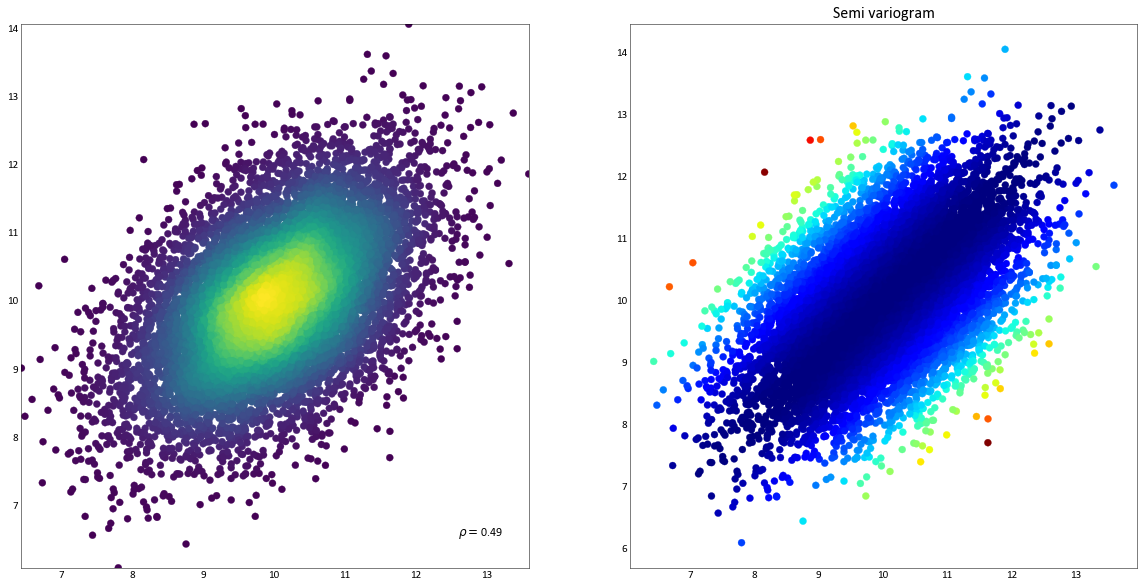

In [75]:
get_stats(data, translate=[1, 1], scale=[2, 3])